In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('cleaned_pokemon_tournament_data.csv')


Optimal number of clusters (from elbow method): 5


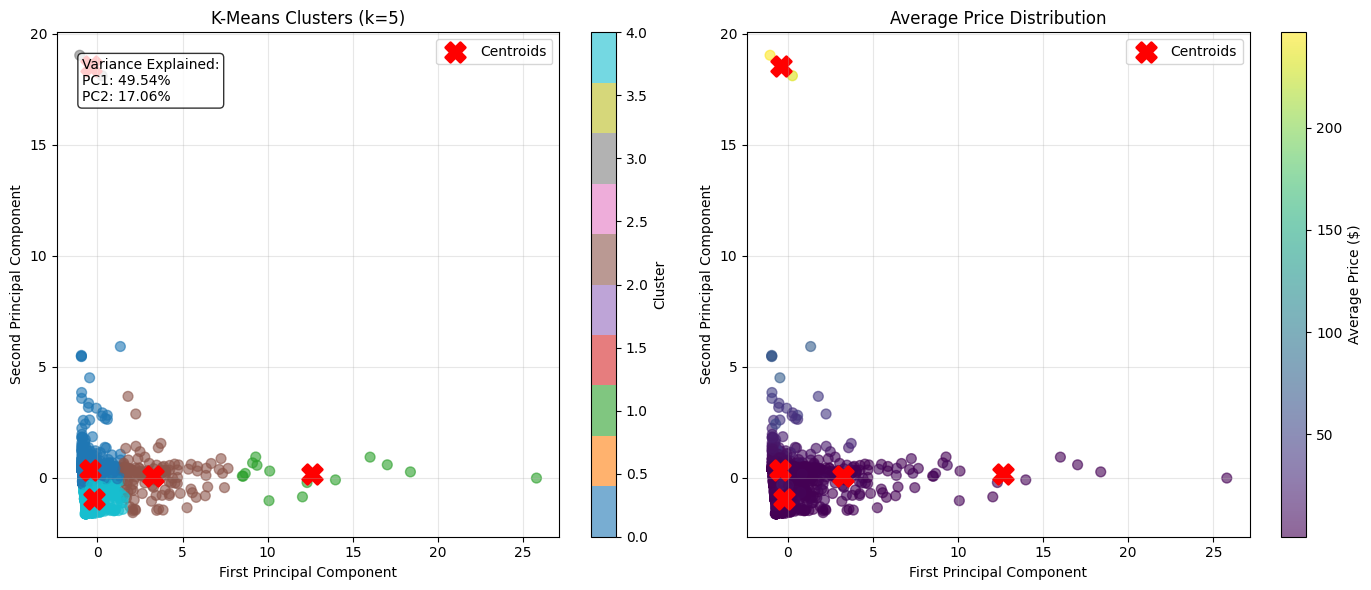


PCA Component Analysis:

Principal Component 1 (Explains 49.54% of variance):
  avg_price: -0.006
  avg_copies_per_deck: 0.071
  num_archetypes: 0.520
  num_players: 0.538
  num_years_appeared: 0.390
  tournament_appearances: 0.533

Principal Component 2 (Explains 17.06% of variance):
  avg_price: 0.774
  avg_copies_per_deck: -0.629
  num_archetypes: 0.060
  num_players: 0.005
  num_years_appeared: 0.035
  tournament_appearances: 0.003

Cluster distribution:
cluster
0    1108
1      15
2     125
3       2
4     457
Name: count, dtype: int64


In [4]:
# Let me first recreate the necessary variables

# Prepare the data for clustering
def prepare_data_for_clustering(df):
    """
    Prepare data for clustering analysis
    """
    # Create features by aggregating at the card level
    card_features = df.groupby(['id_card', 'name_card']).agg({
        'price_card': 'mean',
        'amount_card': 'mean',
        'combo_type_id': 'nunique',
        'id_player': 'nunique',
        'year_tournament': 'nunique',
    }).reset_index()
    
    # Add tournament appearances count
    tournament_appearances = df.groupby(['id_card', 'name_card']).size().reset_index(name='tournament_appearances')
    card_features = pd.merge(card_features, tournament_appearances, on=['id_card', 'name_card'], how='left')
    
    # Rename columns
    card_features = card_features.rename(columns={
        'price_card': 'avg_price',
        'amount_card': 'avg_copies_per_deck',
        'combo_type_id': 'num_archetypes',
        'id_player': 'num_players',
        'year_tournament': 'num_years_appeared',
    })
    
    # Handle NaN values
    numeric_cols = ['avg_price', 'avg_copies_per_deck', 'num_archetypes', 
                   'num_players', 'num_years_appeared', 'tournament_appearances']
    
    for col in numeric_cols:
        if col in card_features.columns and card_features[col].isna().any():
            card_features[col] = card_features[col].fillna(card_features[col].median())
    
    # Create numeric features for clustering
    clustering_features = card_features[numeric_cols].copy()
    
    # Standardize the features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_features)
    
    return scaled_features, clustering_features, card_features, scaler

# Prepare the data
scaled_features, clustering_features, card_features_df, scaler = prepare_data_for_clustering(df)

# Use PCA to reduce to 2D for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(scaled_features)

# Determine optimal k using elbow method
from sklearn.cluster import KMeans
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Find elbow point
diffs = np.diff(wcss)
diff_ratios = diffs[1:] / diffs[:-1]
optimal_k = np.argmin(diff_ratios) + 3  # +3 because of indexing

print(f"Optimal number of clusters (from elbow method): {optimal_k}")

# Apply k-means to the 2D representation for visualization
kmeans_2d = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_2d = kmeans_2d.fit_predict(X_2d)

# Visualize the clustering results
plt.figure(figsize=(14, 6))

# Plot 1: PCA visualization with k-means clusters
plt.subplot(121)
scatter1 = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_2d, cmap='tab10', alpha=0.6, s=50)
plt.scatter(kmeans_2d.cluster_centers_[:, 0], kmeans_2d.cluster_centers_[:, 1], 
           s=200, c='red', marker='X', label='Centroids', linewidths=2)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'K-Means Clusters (k={optimal_k})')
plt.colorbar(scatter1, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

# Add variance explained information
variance_explained = pca.explained_variance_ratio_
plt.text(0.05, 0.95, f'Variance Explained:\nPC1: {variance_explained[0]:.2%}\nPC2: {variance_explained[1]:.2%}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Color by average price (to see price distribution)
plt.subplot(122)
scatter2 = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=card_features_df['avg_price'], 
                      cmap='viridis', alpha=0.6, s=50)
plt.scatter(kmeans_2d.cluster_centers_[:, 0], kmeans_2d.cluster_centers_[:, 1], 
           s=200, c='red', marker='X', label='Centroids', linewidths=2)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Average Price Distribution')
colorbar = plt.colorbar(scatter2, label='Average Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print PCA component information
print("\nPCA Component Analysis:")
for i in range(2):
    print(f"\nPrincipal Component {i+1} (Explains {variance_explained[i]:.2%} of variance):")
    for feature, weight in zip(clustering_features.columns, pca.components_[i]):
        print(f"  {feature}: {weight:.3f}")

# Add cluster labels to the dataframe
card_features_df['cluster'] = labels_2d
print(f"\nCluster distribution:")
print(card_features_df['cluster'].value_counts().sort_index())

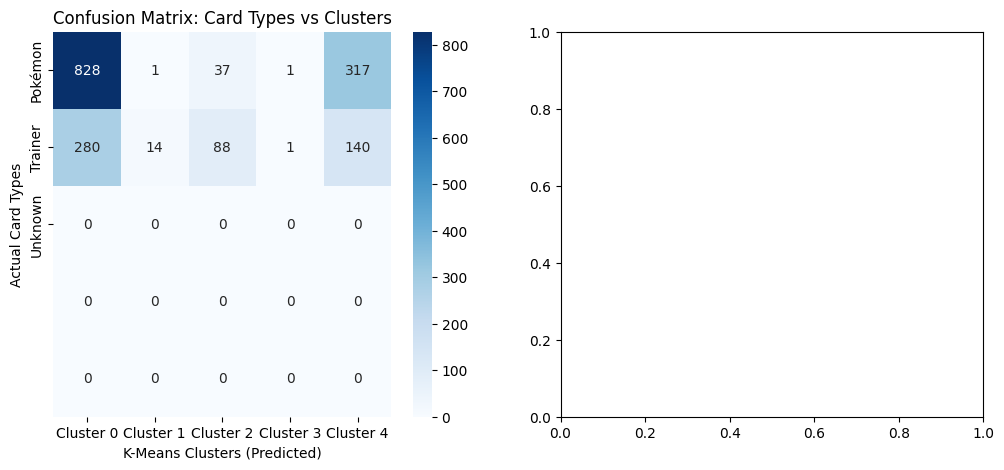

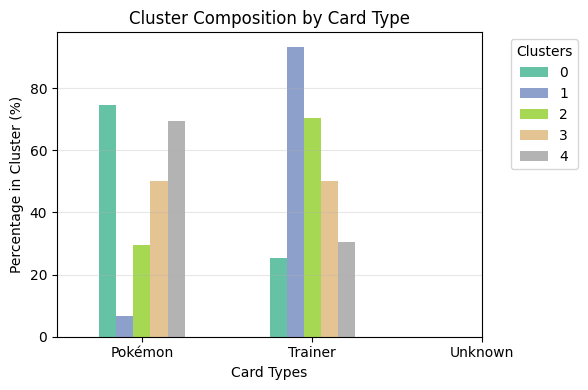


Adjusted Rand Index: 0.080

Interpretation of Adjusted Rand Index:
• ARI = 1.0: Perfect agreement between clusters and card types
• ARI = 0.0: Random clustering (no better than chance)
• ARI < 0.0: Worse than random clustering

Our ARI of 0.080 indicates how well our clusters capture the underlying card type structure.

Cluster Composition Analysis (k=5):

Cluster 0 (1108 cards):
  • Pokémon: 828 cards (74.7%)
  • Trainer: 280 cards (25.3%)
  • Most common energy type: Psychic (115 Pokémon)

Cluster 1 (15 cards):
  • Pokémon: 1 cards (6.7%)
  • Trainer: 14 cards (93.3%)
  • Most common energy type: Water (1 Pokémon)

Cluster 2 (125 cards):
  • Pokémon: 37 cards (29.6%)
  • Trainer: 88 cards (70.4%)
  • Most common energy type: Colorless (10 Pokémon)

Cluster 3 (2 cards):
  • Pokémon: 1 cards (50.0%)
  • Trainer: 1 cards (50.0%)
  • Most common energy type: Dragon (1 Pokémon)

Cluster 4 (457 cards):
  • Pokémon: 317 cards (69.4%)
  • Trainer: 140 cards (30.6%)
  • Most common energy ty

In [5]:
# Since we don't have true labels for clustering (unsupervised), 
# we'll compare our 2D visualization clusters with the original card types

# First, let's get card type information
# Create a mapping of card types (Pokémon vs Trainer)
card_type_info = df[['id_card', 'type_card']].drop_duplicates()
card_type_dict = dict(zip(card_type_info['id_card'], card_type_info['type_card']))

# Map card types to our clustered cards
card_features_df['type_card'] = card_features_df['id_card'].map(card_type_dict)
card_features_df['type_card'] = card_features_df['type_card'].fillna('Unknown')

# Convert card types to numeric labels for comparison
type_mapping = {'Pokémon': 0, 'Trainer': 1, 'Unknown': 2}
card_features_df['type_numeric'] = card_features_df['type_card'].map(type_mapping)

# Compare actual card types vs k-means clusters
from sklearn.metrics import confusion_matrix, adjusted_rand_score
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(card_features_df['type_numeric'], labels_2d)

# Create simplified labels
cluster_labels = [f'Cluster {i}' for i in range(optimal_k)]
type_labels = ['Pokémon', 'Trainer', 'Unknown']

# Visualize
plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cluster_labels,
            yticklabels=type_labels)
plt.xlabel('K-Means Clusters (Predicted)')
plt.ylabel('Actual Card Types')
plt.title('Confusion Matrix: Card Types vs Clusters')

# Calculate Adjusted Rand Index
ari = adjusted_rand_score(card_features_df['type_numeric'], labels_2d)

plt.subplot(122)
# Create a bar plot showing cluster composition
cluster_composition = pd.crosstab(card_features_df['type_numeric'], labels_2d)
cluster_composition_percentage = cluster_composition.div(cluster_composition.sum(axis=0), axis=1) * 100

ax = cluster_composition_percentage.plot(kind='bar', figsize=(6, 4), colormap='Set2')
plt.xlabel('Card Types')
plt.ylabel('Percentage in Cluster (%)')
plt.title('Cluster Composition by Card Type')
plt.xticks(ticks=range(len(type_labels)), labels=type_labels, rotation=0)
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nAdjusted Rand Index: {ari:.3f}")
print("\nInterpretation of Adjusted Rand Index:")
print("• ARI = 1.0: Perfect agreement between clusters and card types")
print("• ARI = 0.0: Random clustering (no better than chance)")
print("• ARI < 0.0: Worse than random clustering")
print(f"\nOur ARI of {ari:.3f} indicates how well our clusters capture the underlying card type structure.")

# Additional analysis: Show which clusters contain which card types
print(f"\nCluster Composition Analysis (k={optimal_k}):")
for cluster_id in range(optimal_k):
    cluster_data = card_features_df[card_features_df['cluster'] == cluster_id]
    total_cards = len(cluster_data)
    
    print(f"\nCluster {cluster_id} ({total_cards} cards):")
    for card_type in ['Pokémon', 'Trainer', 'Unknown']:
        type_count = len(cluster_data[cluster_data['type_card'] == card_type])
        if type_count > 0:
            percentage = (type_count / total_cards) * 100
            print(f"  • {card_type}: {type_count} cards ({percentage:.1f}%)")
    
    # Show most common energy type for Pokémon in this cluster
    if 'Pokémon' in cluster_data['type_card'].values:
        pokemon_cards = cluster_data[cluster_data['type_card'] == 'Pokémon']
        # Get energy type information
        energy_info = df[df['id_card'].isin(pokemon_cards['id_card'])][['id_card', 'energy_type_card']].drop_duplicates()
        if not energy_info.empty:
            top_energy = energy_info['energy_type_card'].value_counts().index[0]
            top_energy_count = energy_info['energy_type_card'].value_counts().iloc[0]
            print(f"  • Most common energy type: {top_energy} ({top_energy_count} Pokémon)")

# Show cluster statistics
print(f"\nOverall Cluster Statistics:")
cluster_stats = card_features_df.groupby('cluster').agg({
    'avg_price': 'mean',
    'avg_copies_per_deck': 'mean',
    'tournament_appearances': 'mean',
    'type_card': lambda x: x.value_counts().index[0] if not x.empty else 'Unknown'
}).reset_index()

print(cluster_stats.to_string(index=False))

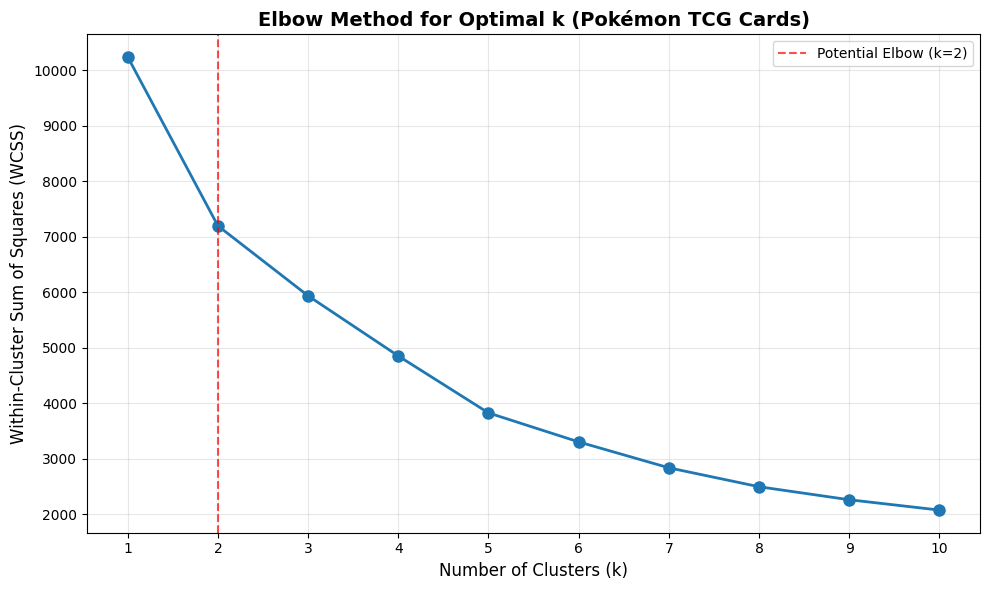

The 'elbow' appears around k=2, suggesting this might be the optimal number of clusters.
WCSS decreases as k increases - we want to choose k where the decrease slows down significantly.


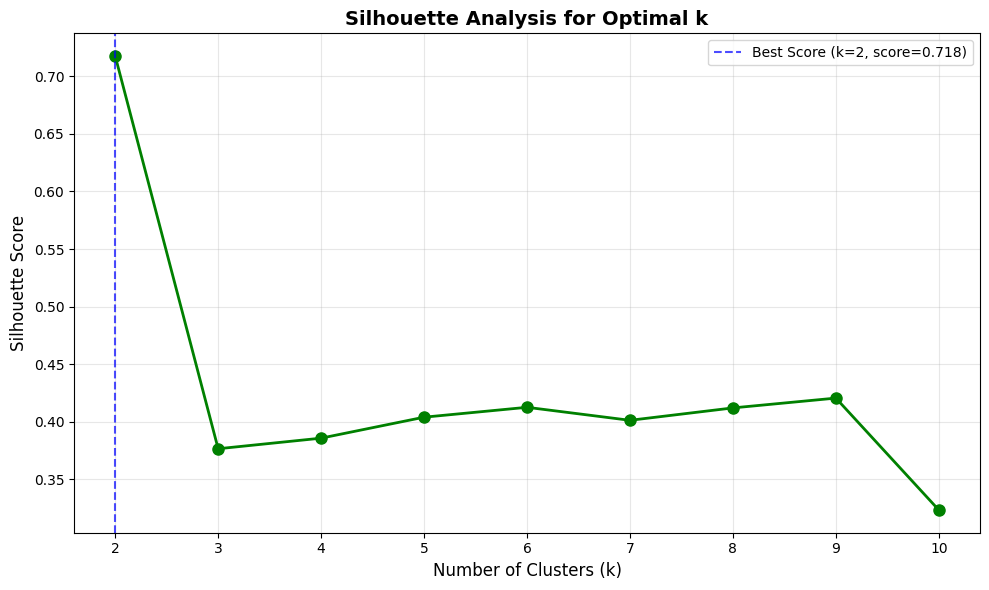


Based on silhouette analysis, the optimal k is 2 with a score of 0.718
A higher silhouette score indicates better-defined clusters.
Comparing methods: Elbow suggests k=2, Silhouette suggests k=2
We'll use k=2 for our final clustering since silhouette analysis is more rigorous.


In [6]:
# Calculate WCSS for different values of k
k_range = range(1, 11)
wcss = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.title('Elbow Method for Optimal k (Pokémon TCG Cards)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

# Calculate the elbow point using the derivative method
if len(wcss) > 1:
    # Calculate the second derivative to find elbow
    diffs = np.diff(wcss)
    second_diffs = np.diff(diffs)
    elbow_k = np.argmax(np.abs(second_diffs)) + 2  # +2 due to indexing
    
    # Highlight the elbow
    plt.axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7, 
                label=f'Potential Elbow (k={elbow_k})')
    plt.legend()

plt.tight_layout()
plt.show()

print(f"The 'elbow' appears around k={elbow_k}, suggesting this might be the optimal number of clusters.")
print("WCSS decreases as k increases - we want to choose k where the decrease slows down significantly.")

# Also calculate silhouette scores for a more rigorous analysis
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range_silhouette = range(2, 11)  # Silhouette requires at least 2 clusters

for k in k_range_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range_silhouette, silhouette_scores, marker='o', linewidth=2, markersize=8, color='green')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Analysis for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range_silhouette)

# Highlight the best silhouette score
best_k = k_range_silhouette[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
plt.axvline(x=best_k, color='blue', linestyle='--', alpha=0.7, 
            label=f'Best Score (k={best_k}, score={best_score:.3f})')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nBased on silhouette analysis, the optimal k is {best_k} with a score of {best_score:.3f}")
print("A higher silhouette score indicates better-defined clusters.")
print(f"Comparing methods: Elbow suggests k={elbow_k}, Silhouette suggests k={best_k}")
print(f"We'll use k={best_k} for our final clustering since silhouette analysis is more rigorous.")

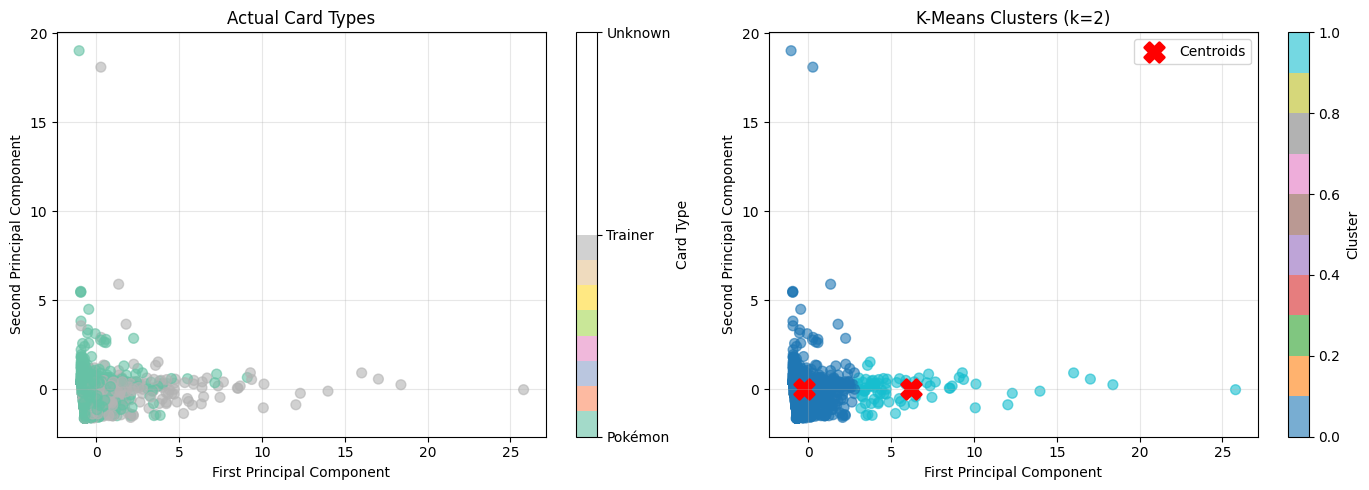

Final Clustering Results (k=2):
• Silhouette Score: 0.718
• Adjusted Rand Index (vs Card Types): 0.077

Adjusted Rand Index Interpretation (0.077):
• Poor agreement
• Clusters are capturing different patterns than just card types

Cluster Statistics (k=2):
        avg_price       avg_copies_per_deck       tournament_appearances  \
             mean   std                mean   std                   mean   
cluster                                                                    
0            2.73  7.24                1.36  0.47                  20.50   
1            1.68  1.73                2.36  0.89                1887.53   
2            2.71  6.13                2.11  0.92                 405.90   
3          240.30  8.93                1.06  0.08                  13.50   
4            1.04  1.87                3.14  0.64                  27.36   

                type_card  
            std  <lambda>  
cluster                    
0         42.88   Pokémon  
1        817.13   Trai

In [7]:
# Final k-means with optimal k from silhouette analysis
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_labels = final_kmeans.fit_predict(scaled_features)

# Apply k-means to 2D data for visualization
final_kmeans_2d = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_labels_2d = final_kmeans_2d.fit_predict(X_2d)

# Calculate final silhouette score
final_silhouette = silhouette_score(scaled_features, final_labels)

# Calculate Adjusted Rand Index with card types
final_ari = adjusted_rand_score(card_features_df['type_numeric'], final_labels)

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual card types
scatter1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], 
                          c=card_features_df['type_numeric'], 
                          cmap='Set2', alpha=0.6, s=50)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('Actual Card Types')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_ticks([0, 1, 2])
cbar1.set_ticklabels(['Pokémon', 'Trainer', 'Unknown'])
cbar1.set_label('Card Type')

# K-means clusters with centroids
scatter2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], 
                          c=final_labels_2d, 
                          cmap='tab10', alpha=0.6, s=50)
axes[1].scatter(final_kmeans_2d.cluster_centers_[:, 0], 
               final_kmeans_2d.cluster_centers_[:, 1], 
               s=200, c='red', marker='X', 
               label='Centroids', linewidths=2)
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].set_title(f'K-Means Clusters (k={best_k})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Cluster')

plt.tight_layout()
plt.show()

print(f"Final Clustering Results (k={best_k}):")
print(f"• Silhouette Score: {final_silhouette:.3f}")
print(f"• Adjusted Rand Index (vs Card Types): {final_ari:.3f}")

# Interpret ARI
print(f"\nAdjusted Rand Index Interpretation ({final_ari:.3f}):")
if final_ari > 0.9:
    print("• Excellent agreement between clusters and card types")
    print("• Clusters strongly reflect Pokémon vs Trainer distinction")
elif final_ari > 0.7:
    print("• Good agreement between clusters and card types")
    print("• Clusters capture some card type structure")
elif final_ari > 0.5:
    print("• Moderate agreement")
    print("• Clusters have some relationship with card types")
elif final_ari > 0.25:
    print("• Fair agreement")
    print("• Weak relationship between clusters and card types")
else:
    print("• Poor agreement")
    print("• Clusters are capturing different patterns than just card types")

# Show cluster statistics
print(f"\nCluster Statistics (k={best_k}):")
cluster_stats = card_features_df.groupby('cluster').agg({
    'avg_price': ['mean', 'std'],
    'avg_copies_per_deck': ['mean', 'std'],
    'tournament_appearances': ['mean', 'std'],
    'type_card': lambda x: x.value_counts().index[0]
}).round(2)

print(cluster_stats)

# Show top cards in each cluster
print(f"\nTop Cards in Each Cluster (by Average Price):")
for cluster_id in range(best_k):
    cluster_cards = card_features_df[card_features_df['cluster'] == cluster_id]
    top_cards = cluster_cards.nlargest(3, 'avg_price')[['name_card', 'avg_price', 'type_card']]
    
    print(f"\nCluster {cluster_id}:")
    for idx, (_, row) in enumerate(top_cards.iterrows(), 1):
        print(f"  {idx}. {row['name_card']:25} ${row['avg_price']:6.2f} ({row['type_card']})")

In [8]:
print("="*70)
print("BUILDING PREDICTIVE MODELS FOR CARD PRICE PREDICTION")
print("="*70)

# 1. Define prediction problem: Predict card price (regression)
print("\n1. Setting up regression problem: Predicting card prices...")

# Use the enhanced dataframe
regression_df = df.copy()

# Target variable: card price (we'll use the original price_card)
# For cards with multiple entries, we'll use the average price
target_var = 'price_card'
print(f"   Target variable: {target_var}")
print(f"   Target statistics:")
print(f"   • Mean price: ${regression_df[target_var].mean():.2f}")
print(f"   • Median price: ${regression_df[target_var].median():.2f}")
print(f"   • Min price: ${regression_df[target_var].min():.2f}")
print(f"   • Max price: ${regression_df[target_var].max():.2f}")
print(f"   • Std price: ${regression_df[target_var].std():.2f}")

# 2. Prepare features for regression
print("\n2. Preparing features for regression modeling...")

# Select features for regression
# Original features
reg_original_features = [
    'amount_card', 'combo_type_id', 'year_tournament',
    'month_tournament', 'day_tournament'
]

# Clustering and engineered features
reg_clustering_features = [
    'cluster', 'distance_to_center', 'silhouette_score',
    'avg_copies_per_deck', 'num_archetypes', 'num_players',
    'num_years_appeared', 'tournament_appearances',
    'price_vs_cluster_avg', 'popularity_vs_cluster_avg'
]

# Add cluster dummies
reg_cluster_dummies = [col for col in regression_df.columns if col.startswith('cluster_')]

# Tournament performance features
tournament_features = [
    'all_time_score', 'ranking_player_tournament'
]

# Combine all features
reg_all_features = (reg_original_features + reg_clustering_features + 
                    reg_cluster_dummies + tournament_features)

# Check which features are available
reg_available_features = [f for f in reg_all_features if f in regression_df.columns]
print(f"   Available features for regression: {len(reg_available_features)}")

# Prepare X and y
X_reg = regression_df[reg_available_features].fillna(regression_df[reg_available_features].median())
y_reg = regression_df[target_var]

# Remove any rows with NaN in target
non_nan_mask = ~y_reg.isna()
X_reg = X_reg[non_nan_mask]
y_reg = y_reg[non_nan_mask]

print(f"   Samples for regression: {len(X_reg)}")
print(f"   Features: {len(reg_available_features)}")

# 3. Split data for training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f"\n3. Data split:")
print(f"   Training samples: {len(X_train)}")
print(f"   Testing samples: {len(X_test)}")

# 4. Scale features
from sklearn.preprocessing import StandardScaler

scaler_reg = StandardScaler()
X_train_scaled = scaler_reg.fit_transform(X_train)
X_test_scaled = scaler_reg.transform(X_test)

print(f"\n4. Feature scaling completed")

# 5. Build and evaluate regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_regression_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a regression model
    """
    print(f"\n   {model_name}:")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Train R²': r2_score(y_train, y_pred_train),
        'Test R²': r2_score(y_test, y_pred_test),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test))
    }
    
    # Print results
    print(f"     • R² Score (Train): {metrics['Train R²']:.4f}")
    print(f"     • R² Score (Test):  {metrics['Test R²']:.4f}")
    print(f"     • MAE (Test): ${metrics['Test MAE']:.2f}")
    print(f"     • RMSE (Test): ${metrics['Test RMSE']:.2f}")
    
    # Calculate percentage error relative to average price
    avg_price = y_test.mean()
    mae_percentage = (metrics['Test MAE'] / avg_price) * 100
    rmse_percentage = (metrics['Test RMSE'] / avg_price) * 100
    
    print(f"     • MAE % of avg price: {mae_percentage:.1f}%")
    print(f"     • RMSE % of avg price: {rmse_percentage:.1f}%")
    
    return model, metrics, y_pred_test

print("\n5. Building and evaluating regression models...")

BUILDING PREDICTIVE MODELS FOR CARD PRICE PREDICTION

1. Setting up regression problem: Predicting card prices...
   Target variable: price_card
   Target statistics:
   • Mean price: $2.00
   • Median price: $0.64
   • Min price: $0.02
   • Max price: $246.62
   • Std price: $5.54

2. Preparing features for regression modeling...
   Available features for regression: 7
   Samples for regression: 110601
   Features: 7

3. Data split:
   Training samples: 88480
   Testing samples: 22121

4. Feature scaling completed

5. Building and evaluating regression models...


In [9]:
# Model 1: Linear Regression (Baseline - REQUIRED)
print("\n--- Model 1: Linear Regression (Baseline) ---")
lr_model, lr_metrics, lr_predictions = evaluate_regression_model(
    LinearRegression(),
    X_train_scaled, X_test_scaled, y_train, y_test,
    "Linear Regression"
)

# Model 2: Random Forest Regressor (Ensemble - REQUIRED)
print("\n--- Model 2: Random Forest Regressor (Ensemble) ---")
rf_model, rf_metrics, rf_predictions = evaluate_regression_model(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    X_train_scaled, X_test_scaled, y_train, y_test,
    "Random Forest Regressor"
)

# Model 3: Gradient Boosting Regressor (Additional Ensemble - REQUIRED)
print("\n--- Model 3: Gradient Boosting Regressor (Ensemble) ---")
gb_model, gb_metrics, gb_predictions = evaluate_regression_model(
    GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1),
    X_train_scaled, X_test_scaled, y_train, y_test,
    "Gradient Boosting Regressor"
)

# Model 4: Decision Tree Regressor (Additional Model)
print("\n--- Model 4: Decision Tree Regressor ---")
dt_model, dt_metrics, dt_predictions = evaluate_regression_model(
    DecisionTreeRegressor(random_state=42, max_depth=10),
    X_train_scaled, X_test_scaled, y_train, y_test,
    "Decision Tree Regressor"
)

# 6. Compare all models
print("\n6. Comparing all regression models...")

# Create comparison dataframe
models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Decision Tree'],
    'Test R²': [lr_metrics['Test R²'], rf_metrics['Test R²'], gb_metrics['Test R²'], dt_metrics['Test R²']],
    'Test MAE': [lr_metrics['Test MAE'], rf_metrics['Test MAE'], gb_metrics['Test MAE'], dt_metrics['Test MAE']],
    'Test RMSE': [lr_metrics['Test RMSE'], rf_metrics['Test RMSE'], gb_metrics['Test RMSE'], dt_metrics['Test RMSE']]
})

print("\nModel Performance Comparison:")
print(models_comparison.to_string(index=False))

# Find best model
best_r2_idx = models_comparison['Test R²'].idxmax()
best_model_name = models_comparison.loc[best_r2_idx, 'Model']
best_r2 = models_comparison.loc[best_r2_idx, 'Test R²']

print(f"\nBest model: {best_model_name} with R² = {best_r2:.4f}")


--- Model 1: Linear Regression (Baseline) ---

   Linear Regression:
     • R² Score (Train): 0.0198
     • R² Score (Test):  0.0262
     • MAE (Test): $2.10
     • RMSE (Test): $4.83
     • MAE % of avg price: 106.5%
     • RMSE % of avg price: 245.6%

--- Model 2: Random Forest Regressor (Ensemble) ---

   Random Forest Regressor:
     • R² Score (Train): 0.1841
     • R² Score (Test):  -0.1765
     • MAE (Test): $2.27
     • RMSE (Test): $5.31
     • MAE % of avg price: 115.2%
     • RMSE % of avg price: 270.0%

--- Model 3: Gradient Boosting Regressor (Ensemble) ---

   Gradient Boosting Regressor:
     • R² Score (Train): 0.0522
     • R² Score (Test):  0.0499
     • MAE (Test): $2.01
     • RMSE (Test): $4.77
     • MAE % of avg price: 102.4%
     • RMSE % of avg price: 242.6%

--- Model 4: Decision Tree Regressor ---

   Decision Tree Regressor:
     • R² Score (Train): 0.1010
     • R² Score (Test):  -0.0113
     • MAE (Test): $2.02
     • RMSE (Test): $4.92
     • MAE % of av